# RNN 실습 1

  1. Dataset: IMDB Large movie review 데이터셋
  2. 데이터 전처리
  3. 모델 생성
  4. Compile
  5. 학습
  6. 평가(Evaluation)



## Setup.

**Import Library**

In [1]:
!pip install -q -U tensorflow
!pip install -q tensorflow_datasets

You should consider upgrading via the 'C:\Users\82106\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\82106\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [22]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**Helper function for plot graphs**

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## 1. Load dataset

In [24]:
#tfds.load 함수를 사용하여 'imdb_reviews'라는 데이터셋을 로드
#with_info=True는 데이터셋에 대한 메타정보(예: 데이터셋의 구조, 클래스의 수, 샘플의 수 등)도 함께 로드하도록 지정
#as_supervised=True는 데이터를 감독학습(supervised learning) 형식으로 로드하도록 설정
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

#로드된 데이터셋에서 훈련용 데이터셋(train_dataset)과 테스트용 데이터셋(test_dataset)을 분리
train_dataset, test_dataset = dataset['train'], dataset['test']

#train_dataset.take(1)은 훈련 데이터셋에서 첫 번째 샘플만을 가져오는 코드
#example.numpy()와 label.numpy()는 각각 텍스트 데이터와 레이블 데이터를 NumPy 배열로 변환하여 출력한다. 
#텍스트는 리뷰의 내용이고, 레이블은 리뷰의 긍정(1) 또는 부정(0) 여부를 나타낸다
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


TensorFlow와 TensorFlow Datasets 라이브러리를 사용하여 IMDB 영화 리뷰 데이터셋을 로드하고, 간단하게 첫 번째 샘플을 출력

훈련 데이터셋에서 첫 번째 리뷰와 해당 리뷰의 긍정/부정 레이블이 출력

**Shuffle and create batchs**

In [25]:
#BUFFER_SIZE는 데이터셋을 섞을 때 사용되는 버퍼의 크기를 설정
BUFFER_SIZE = 10000

#BATCH_SIZE는 한 번에 처리할 데이터의 수를 정의한다. 이 크기에 따라 각 배치에 포함된 샘플의 수가 결정된다.
BATCH_SIZE = 64

#shuffle(BUFFER_SIZE)는 데이터셋을 무작위로 섞는다
#prefetch(tf.data.AUTOTUNE)는 훈련 데이터의 로딩 시간을 줄이기 위해 데이터 로딩 작업을 학습 작업과 겹쳐서 수행한다
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#테스트 데이터셋에서는 shuffle을 사용하지 않는다. 테스트 데이터의 순서는 결과에 영향을 주지 않기 때문이다.
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

훈련 및 테스트 데이터셋을 배치 처리하고, 효율적인 데이터 로딩을 위해 선처리하는 과정을 설정

-> 모델 설계전 하이퍼파라미터 설정

In [26]:
#train_dataset.take(1)는 훈련 데이터셋에서 첫 번째 배치만을 가져오도록 지정
for example, label in train_dataset.take(1):

  #example.nWumpy()는 현재 배치의 모든 텍스트 샘플을 NumPy 배열로 변환
  print('texts: ', example.numpy()[:3])
  print()

  #label.numpy()는 해당 배치의 모든 레이블을 NumPy 배열로 변환
  print('labels: ', label.numpy()[:3])

texts:  [b"An MGM MINIATURE Short Subject.<br /><br />The editor of the Cole County Clarion must decide what is the real IMPORTANT NEWS for his readers: an impending frost which may spell disaster to their crops, or the sensational shooting-down of a notorious gangster on their small town main street.<br /><br />This is an enjoyable little one-reeler, featuring a good performance by comic Charles `Chic' Sale. Today's viewers will perhaps be more interested in the appearance of uncredited James Stewart, as Sale's nephew/assistant. Slow talking & somewhat goofy, Stewart shows many of the attributes which would make him a huge star in a very short time.<br /><br />Often overlooked or neglected today, the one and two-reel short subjects were useful to the Studios as important training grounds for new or burgeoning talents, both in front & behind the camera. The dynamics for creating a successful short subject was completely different from that of a feature length film, something like writi

실제 데이터셋에서 특정 배치를 빠르게 살펴보고, 그 내용을 확인하기 위해 사용될 수 있다. 

## 2. 데이터 전처리

In [29]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# 데이터셋에서 텍스트만 추출하여 encoder를 적응시킵니다.
encoder.adapt(train_dataset.map(lambda text, label: text))


어휘 사전 크기 설정: VOCAB_SIZE는 모델이 인식할 수 있는 최대 단어 수를 설정한다. 여기서는 1000개의 단어로 제한된다.

TextVectorization 레이어 생성: 이 레이어는 텍스트를 자동으로 토큰화하고, 토큰을 숫자 인덱스로 매핑하여 머신 러닝 모델이 처리할 수 있는 형태로 변환한다.

레이어 적응: encoder.adapt() 메서드는 훈련 데이터셋의 텍스트 데이터만을 사용하여 TextVectorization 레이어를 '적응'시키며, 이 과정에서 내부적으로 사용될 어휘 사전을 생성한다.

어휘 사전 추출: encoder.get_vocabulary() 메서드로 생성된 어휘 사전을 가져와서 이를 NumPy 배열로 변환하고, 상위 20개의 단어를 출력한다

텍스트 데이터를 기계 학습 모델이 처리할 수 있는 형태로 변환하는 중요한 단계로, 모델이 텍스트를 이해하고 학습할 수 있도록 돕는다

**Encoding**

In [30]:
#텍스트 데이터 example을 토큰화하고, 각 토큰(단어)을 어휘 사전에 정의된 인덱스로 변환
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 34,   1,   1, ...,   0,   0,   0],
       [ 39, 377,  10, ...,   0,   0,   0],
       [861,   1,   7, ...,   0,   0,   0]], dtype=int64)

encoded_example 변수는 TextVectorization 레이어를 사용하여 주어진 텍스트 샘플들(example)을 정수 인코딩한 결과를 담고 있다.

 여기서 사용된 encoder 레이어는 텍스트를 받아 내부 어휘 사전에 따라 각 단어를 해당하는 정수로 매핑한다. 
 
 각 정수는 어휘 사전에서의 단어 위치를 나타낸다.

## 3. RNN Model



```python
tf.keras.layers.LSTM(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', unit_forget_bias=True,
    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
    bias_constraint=None, dropout=0.0, recurrent_dropout=0.0,
    return_sequences=False, return_state=False, go_backwards=False, stateful=False,
    time_major=False, unroll=False, **kwargs
)
```



In [32]:
model = tf.keras.Sequential([

    #텍스트를 숫자로 변환하는 TextVectorization 레이어
    encoder,

    #tf.keras.layers.Embedding 레이어는 정수 인코딩된 텍스트를 받아 각 정수(단어 인덱스)를 해당하는 고차원 벡터로 매핑
    tf.keras.layers.Embedding(
        
        #input_dim은 어휘 사전의 크기로, 인코더에서 생성된 어휘 사전의 총 단어 수
        input_dim=len(encoder.get_vocabulary()),

        #output_dim은 각 단어를 표현할 벡터의 차원
        output_dim=64,

        # 패딩된 0 값을 마스킹하여 네트워크가 이를 무시하도록 한다
        mask_zero=True),
    
    #Long Short-Term Memory 레이어로, 64개의 유닛을 가지며, 시퀀스 데이터의 장기 의존성을 학습하는 데 유용
    #이 레이어는 텍스트 데이터의 문맥을 파악하는 데 중요한 역할
    tf.keras.layers.LSTM(64),

    # 64개의 유닛을 가진 완전 연결(fully-connected) 레이어. 활성화 함수로 ReLU(Rectified Linear Unit)을 사용
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

### -> 모델을 설계

encoder 를 사용하여 Sequential 모델을 설계한다. 

가장먼저 embedding 레이어를 만들어 정수 인코딩 텍스트를 각 정수에 해당하는 고차원 벡터로 매핑한다

그다음 LSTM 레이어에서는 텍스트 데이터의 문맥을 파악한다.

그다음은 Dense 레이어로 64개의 유닛을 완전연결하는 레이어이다.

마지막 Dense 레이어는 최종 예측 값을 생성 하는 레이어이다. 

Dense 레이어의 뉴런 구조:

뉴런: Dense 레이어에는 각각의 뉴런이 있다. 예를 들어, 64개의 뉴런을 가진 Dense 레이어는 64개의 독립적인 뉴런으로 구성되어 있으며, 각 뉴런은 입력으로부터 모든 값을 받아 처리한다.

가중치와 편향: 각 뉴런은 자신만의 가중치 세트를 가지고 있다. 이 가중치들은 입력 값과 곱해져서 뉴런의 출력을 결정하는데 기여한다. 또한, 각 뉴런에는 편향 값도 추가되어, 뉴런의 출력을 조정한다.

활성화 함수: 모든 계산이 끝난 후, 결과값은 활성화 함수를 통과하여 최종 출력을 생성한다. 활성화 함수는 신경망이 비선형 문제를 해결할 수 있도록 도와주며, 일반적으로 ReLU, Sigmoid, Tanh 등이 사용된다.

1. 순환 구조:
LSTM은 순환적 구조를 가지고 있어, 각 시점의 입력(현재 단어)과 이전 시점에서의 상태(이전 단어들의 정보)를 함께 고려한다. 이를 통해, 네트워크는 한 시점에서 다음 시점으로 정보를 전달하면서 텍스트를 통한 정보의 흐름을 모델링할 수 있다.

2. 메모리 셀:
LSTM의 핵심은 '메모리 셀'이라고 불리는 구조이다. 이 셀은 시간이 지나도 정보를 유지할 수 있는 능력을 가지고 있어, 장기적인 의존성을 기억하는 데 유용하다. 예를 들어, 문장의 처음에 등장하는 주요 주제를 문장의 끝에서 다시 언급할 수 있다.

3. 게이트 메커니즘:
LSTM은 입력 게이트, 망각 게이트, 출력 게이트라는 세 가지 주요 게이트를 사용한다. 이 게이트들은 어떤 정보를 셀 상태에 추가할지, 삭제할지, 출력할지를 결정하는 데 중요한 역할을 합니다. 이를 통해 불필요한 정보는 제거하고, 중요한 정보는 보존한다.
입력 게이트: 현재 입력과 이전 상태를 기반으로 새로운 정보를 얼마나 셀 상태에 추가할지 결정한다.
망각 게이트: 기존의 셀 상태에서 어떤 정보를 잊을지 결정합니다. 이는 정보의 오래된 부분을 제거하는 데 중요하다.
출력 게이트: 현재의 셀 상태에서 어떤 정보를 다음 레이어로 보낼지 결정한다.

4. 문맥 이해:
LSTM은 이러한 구조를 통해 각 단어가 주어졌을 때 이전 단어들의 맥락을 기억하면서 어떻게 현재 단어와 관련되는지를 학습한다. 예를 들어, "He said that he would come because..." 같은 문장에서 "because" 다음에 올 단어를 예측할 때, 문장의 전체적인 의미를 이해하는 데 LSTM이 유용하다.

## 4. Compile

In [33]:
model.compile(

#모델이 예측을 얼마나 잘 하고 있는지를 평가하는 지표
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

              #모델의 가중치를 업데이트하는 방법을 결정
              #1e-4는 학습률(learning rate)로, 이 값은 매 학습 단계에서 얼마나 크게 가중치를 조정할지를 결정
              optimizer=tf.keras.optimizers.Adam(1e-4),

              #모델이 얼마나 정확하게 입력 데이터의 레이블을 예측하는지를 나타낸다
              metrics=['accuracy'])

### 모델의 학습 방법에 대한 여러 설정들을 지정

BinaryCrossentropy를 통해 이진분류를 평가한다. 이에 손실함수를 활용한다

학습률을 정하여 가중치를 어떻게 업데이트할건지를 결정한다.

accuracy 방법으로 데이터의 레이블을 예측을 얼마나 정확하게 하는지 나타낸다.

### 5. 학습

In [34]:
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/3


391/391 ━━━━━━━━━━━━━━━━━━━━ 203s 507ms/step - accuracy: 0.5115 - loss: 0.6807 - val_accuracy: 0.8026 - val_loss: 0.4708
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 177s 452ms/step - accuracy: 0.8034 - loss: 0.4306 - val_accuracy: 0.8406 - val_loss: 0.3437
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 522ms/step - accuracy: 0.8500 - loss: 0.3507 - val_accuracy: 0.8531 - val_loss: 0.3333


훈련 데이터셋: 모델이 학습할 데이터

에포크(Epochs): 전체 훈련 데이터셋이 모델을 통해 학습되는 횟수.각 에포크마다 모델의 성능이 점차 개선될 수 있다

검증 데이터셋: 이는 모델의 학습 과정을 검증하기 위해 사용되는 데이터셋

검증 스텝(Validation Steps): 검증 데이터셋에서 수행할 배치 처리의 수를 지정

학습 과정에서 발생한 손실(loss)과 평가 지표(metrics) 값들을 담고 있는 History 객체

## 6. 평가

In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.8339 - loss: 0.3533
Test Loss: 0.3508470952510834
Test Accuracy: 0.8360400199890137


(0.0, 0.648514150083065)

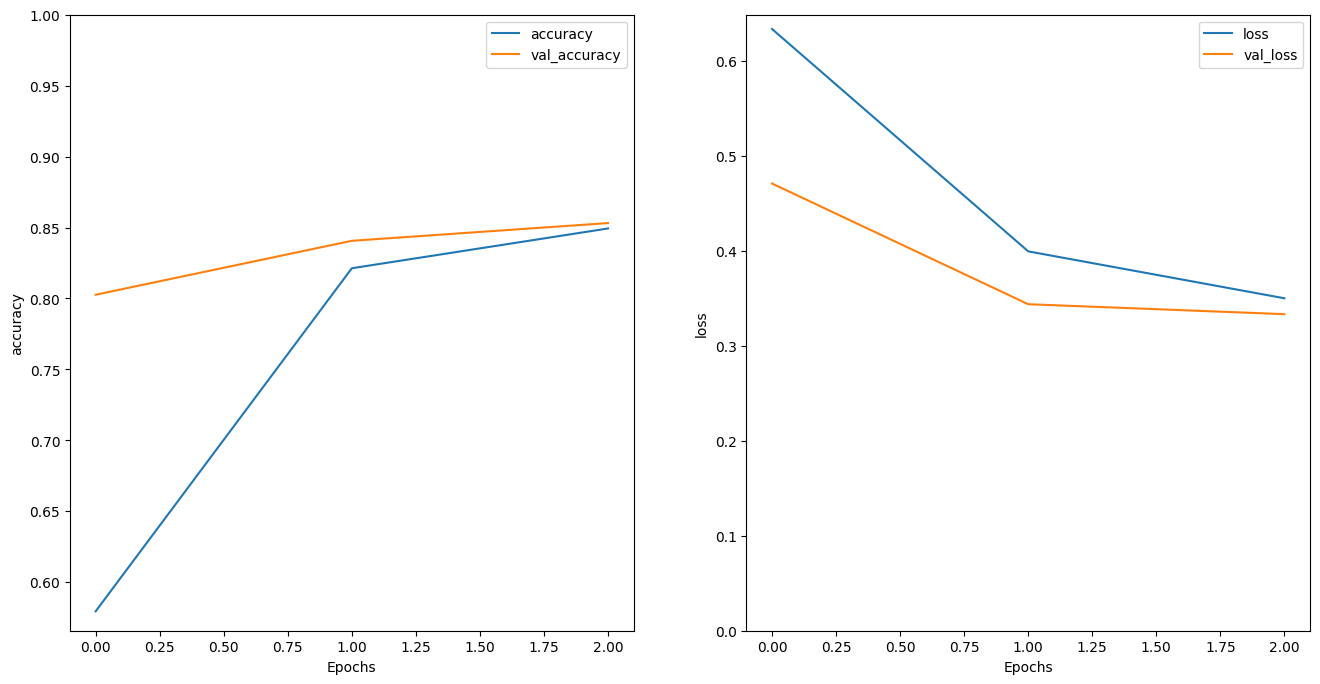

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

검증 데이터에 대한 정확도도 비슷하게 증가하고 있으나, 훈련 데이터에 비해 약간 낮은 경향을 보인다

에포치가 증가할수록 두 데이터셋의 정확도나 손실률은 비슷해지는것을 볼수있다.